# LISA Analysis on 2019 and 2022 Inside Airbnb 

## Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

### Standardiser

In [3]:
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

### Customised Functions

#### Plotting Function

In [4]:
# This is the plotting function Jon wrote

def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways or allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

#### Caching Function

In [5]:
import os
from requests import get
from urllib.parse import urlparse

# This is the cache function Jon wrote
def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    # os.path.getsize() gets the size of the file
    # if it doesn't exist, its size is less than 1
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Import Raw Data

This section will focus on cleaning raw airbnb data from 2019.

By the end of this section, we will get a new dataframe which only contains columns that we are interested in.

### 2019, 2022 Raw Airbnb Data

In [6]:
# read in 2019 airbnb raw data
airbnb_raw_2019 = pd.read_csv('London-2019-listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_raw_2019.shape[0]:,} x {airbnb_raw_2019.shape[1]}")

Data frame is 85,068 x 106


In [7]:
# read in 2022 airbnb raw data
airbnb_raw_2022 = pd.read_csv('listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_raw_2022.shape[0]:,} x {airbnb_raw_2022.shape[1]}")

Data frame is 69,351 x 75


### London Borough Image

In [8]:
# some shapefiles
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

Found data/geo/Boroughs.gpkg locally!


In [9]:
# boros
boros.head(n=1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."


## General Data Cleaning: Booleans, Dates, Categories, Price Strings, Geography
**Most of this code comes from practical 5**

**In this section, I clean the entire dataset before selecting specific columns. This is for the purpose of reproducibility; individuals can select other fields in the Inside Airbnb dataset to expand upon this analysis.**

In [10]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. 
# This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

### Boolean

In [11]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [12]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
# 2019 Raw Airbnb Data 
for b in bcols:
    print(f"Converting {b}")
    airbnb_raw_2019[b] = airbnb_raw_2019[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [13]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
# 2022 Raw Airbnb Data 
for b in bcols:
    print(f"Converting {b}")
    airbnb_raw_2022[b] = airbnb_raw_2022[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


### Date

In [14]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']

In [15]:
for d in dates:
    print("Converting " + d)
    airbnb_raw_2019[d] = pd.to_datetime(airbnb_raw_2019[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [16]:
for d in dates:
    print("Converting " + d)
    airbnb_raw_2022[d] = pd.to_datetime(airbnb_raw_2022[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


### Category

In [17]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']

In [18]:
for c in cats:
    print(f"Converting {c}")
    airbnb_raw_2019[c] = airbnb_raw_2019[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


In [19]:
for c in cats:
    print(f"Converting {c}")
    airbnb_raw_2022[c] = airbnb_raw_2022[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


### Price and String Values

In [20]:
money = ['price']

# part of the issue here was that you had to remove the commas as well 
# because it wouldn't convert to a float if you just removed the $
for m in money:
    print(f"Converting {m}")
    airbnb_raw_2019[m] = airbnb_raw_2019[m].str.replace('$','', 
                                              regex=False).str.replace(',','', 
                                                                       regex=False).astype('float')


Converting price


In [21]:
money = ['price']

# part of the issue here was that you had to remove the commas as well 
# because it wouldn't convert to a float if you just removed the $
for m in money:
    print(f"Converting {m}")
    airbnb_raw_2022[m] = airbnb_raw_2022[m].str.replace('$','', 
                                              regex=False).str.replace(',','', 
                                                                       regex=False).astype('float')


Converting price


### Converting other Values to Pandas Integers

In [22]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_raw_2019[i] = airbnb_raw_2019[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_raw_2019[i] = airbnb_raw_2019[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


In [23]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_raw_2022[i] = airbnb_raw_2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_raw_2022[i] = airbnb_raw_2022[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


### Create a new DataFrame

This dataframe will be used for analysis which contains columns that we need!

In [24]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price']

In [25]:
airbnb_2019 = airbnb_raw_2019[fcols]
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")

Data frame is 85,068 x 15


In [26]:
airbnb_2022 = airbnb_raw_2022[fcols]
print(f"Data frame is {airbnb_2022.shape[0]:,} x {airbnb_2022.shape[1]}")

Data frame is 69,351 x 15


## Data Cleaning

In [27]:
# create a column of geometry
gdf_2019 = gpd.GeoDataFrame(airbnb_2019, geometry=gpd.points_from_xy(airbnb_2019.longitude, airbnb_2019.latitude))

In [28]:
# create a column of geometry
gdf_2022 = gpd.GeoDataFrame(airbnb_2022, geometry=gpd.points_from_xy(airbnb_2022.longitude, airbnb_2022.latitude))

In [29]:
# set aribnb 2019/2022 crs
gdf_2019.set_crs(epsg=4326, inplace=True)
gdf_2022.set_crs(epsg=4326, inplace=True)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, United Kingdom",3,4,51.57,-0.11,Private room in rental unit,Private room,1,29,Islington,50.00,POINT (-0.11270 51.56861)
1,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,"Kensington, United Kingdom",1,12,51.49,-0.17,Entire rental unit,Entire home/apt,3,50,Kensington and Chelsea,75.00,POINT (-0.16813 51.48780)
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,"London, United Kingdom",1,3,51.53,-0.07,Entire rental unit,Entire home/apt,5,365,Tower Hamlets,90.00,POINT (-0.07426 51.52851)
3,106332,"Lovely large room, Bethnal Green",Lovely characterful room in a house belonging ...,264345,"London, United Kingdom",2,5,51.53,-0.05,Private room in home,Private room,3,365,Tower Hamlets,55.00,POINT (-0.05396 51.52874)
4,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,67564,"London, United Kingdom",6,32,51.52,-0.14,Entire rental unit,Entire home/apt,4,365,Westminster,379.00,POINT (-0.14094 51.52195)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69346,9671724,"Cozy room in Greenwich, river view","Single room available in a new three bedroom, ...",49977905,"England, United Kingdom",15,15,51.48,-0.01,Private room in rental unit,Private room,5,7,Greenwich,55.00,POINT (-0.01346 51.48300)
69347,20277958,River view Tate Modern,"Best location in London, overlooking Thames Ri...",1132775,"London, United Kingdom",1,1,51.51,-0.10,Entire condo,Entire home/apt,3,28,Southwark,201.00,POINT (-0.10192 51.50914)
69348,20512703,"Luxury 4 bed house, 100m to river and palace",Forget your worries in this spacious and seren...,1706966,"London, United Kingdom",1,1,51.41,-0.35,Entire home,Entire home/apt,3,365,Richmond upon Thames,246.00,POINT (-0.35325 51.40571)
69349,49698549,Waterfront Hampton Stay,This luxury waterfront home is located on a ti...,34213667,"London, United Kingdom",1,1,51.41,-0.36,Entire bungalow,Entire home/apt,3,1125,Richmond upon Thames,250.00,POINT (-0.35975 51.41029)


In [30]:
# reproject airbnb crs
gdf_2019 = gdf_2019.to_crs(epsg=27700)
gdf_2022 = gdf_2022.to_crs(epsg=27700)

In [31]:
gdf_2022.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, United Kingdom",3,4,51.57,-0.11,Private room in rental unit,Private room,1,29,Islington,50.00,POINT (530901.013 187213.787)


In [32]:
# rename a column
gdf_2019.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)
gdf_2022.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)

In [33]:
# merge airbnb and borough shapefile 
boro_listings_2019 = gpd.sjoin(gdf_2019, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = 'index_right')

boro_listings_2022 = gpd.sjoin(gdf_2022, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = 'index_right')

## Listings with Words Tied to Gentrification & Hotels/Hostels
**This code draws from practical 7. Here, I target descriptions using text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. The main purpose of this section is to identify on a map where listings that buy into narratives surrounding gentrification are located.**

**Because I am working on NLP, I will drop all the description rows that have null values because I will primarily be working with the descriptions.**

In [34]:
gdf1 = boro_listings_2019.dropna(subset=['description'])
print(f"Now gdf has {gdf1.shape[0]:,} rows and {gdf1.shape[1]:,} columns")

gdf2 = boro_listings_2022.dropna(subset=['description'])
print(f"Now gdf has {gdf2.shape[0]:,} rows and {gdf2.shape[1]:,} columns")

Now gdf has 82,673 rows and 18 columns
Now gdf has 67,092 rows and 18 columns


In [35]:
gdf1[~gdf1.description.isna()].description.sample(10, random_state=42)
#It seems there are more or less the same issues as in the practical regarding the descriptions

18299    Newly renovated flat and located on a beautifu...
15624    An award winning, very comfortable flat in qui...
18280    Peace and quiet right in the heart of East Lon...
33925    A flat with 2 double beds only a few minutes w...
55527    The flat is located in a former church hall bu...
38738    Professionally managed one bedroom apartment i...
21567    This is a 3 bedroom appartament with no living...
84775    Spacious 4 double bedroom, 2 bathroom, 4 beds ...
10200    Three fully furnished spacious bedrooms (2 dou...
6644     Located in popular Fulham area, my home is com...
Name: description, dtype: object

In [36]:
gdf1.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description but rather a way of shortening it

'Top floor flat share with great light throughout the day and surrounded by gardens. The bedroom includes a corner study with views to the garden. You will be sharing the flat with 2 lovely people. Access to the bathroom, kitchen and living room is shared. There is a piano and a 50" TV in the living room. Happy to send extra pictures upon request :) The area has some of the best transport links in London; underground to Oxford Street in 12 minutes, direct trains to Gatwick and Luton Airports. 5 minutes from the tube, overground and 3 minutes from Thameslink trains to Gatwick, Luton and Central London!'

In [37]:
#remove html
for col in gdf1.select_dtypes(include='object'):
    gdf1['description'] = gdf1['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    
for col in gdf2.select_dtypes(include='object'):
    gdf2['description'] = gdf2['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())    

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [38]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf1['description']:
    punkt.append(re.sub(pattern, ' ', l))

In [39]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf2['description']:
    punkt.append(re.sub(pattern, ' ', l))

Below, I am using the package 'textual' written for practical 7 that should do more or less the same thing as above. However, it will go further to remove stopwords, words with accents, special characters, digits, as well as lemmatise the text. This *could* double count some of the lower case, removal of punct and html that I've already done OR it could just be sure it worked. But, I think it's important to have done that above because it ended up catching more listings (about 100) than without the NLP.

In [40]:
#Regex for words often associated with gentrification:
gent_2019 = gdf1[gdf1.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent_2019.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 10,485 records for airbnbs in areas that might be gentrifying


In [41]:
#Regex for words often associated with gentrification:
gent_2022 = gdf2[gdf2.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent_2022.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 5,704 records for airbnbs in areas that might be gentrifying


In [42]:
# #Regex for words often associated with hotels/hostels:
# hotels = gd2f[gdf2.description.str.contains( r'\b(?:hotel|hostel)\b', regex=True, flags=re.IGNORECASE)].copy()
# print(f"Found {hotels.shape[0]:,} records for airbnbs in areas that might be hotels or hostels")

In [43]:
%load_ext autoreload
%autoreload 2
from textual import *

All NLTK libraries installed...


In [44]:
# I commented it cos it took a long time to run this code chunk
# gent['description_norm'] = gent.description.apply(normalise_document, remove_digits=True)

In [45]:
print(boros.crs)
print(gent_2019.crs)
print(gent_2022.crs)

epsg:27700
epsg:27700
epsg:27700


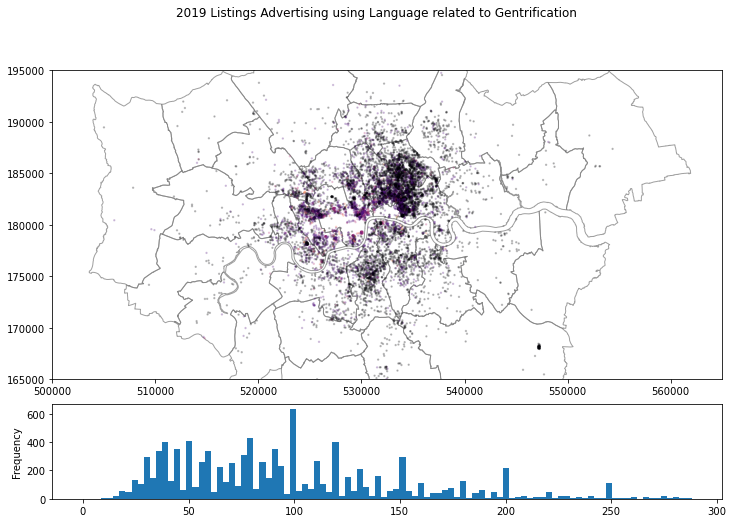

In [46]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent_2019.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent_2019[gent_2019.price<gent_2019.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("2019 Listings Advertising using Language related to Gentrification")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

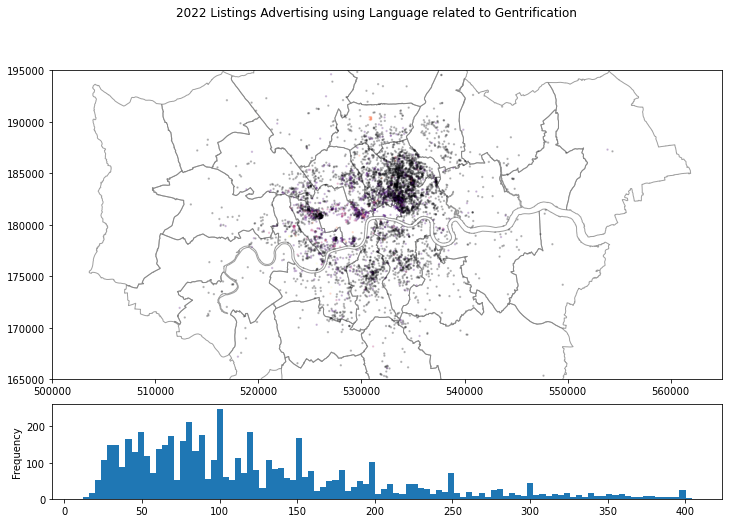

In [47]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent_2022.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent_2022[gent_2022.price<gent_2022.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("2022 Listings Advertising using Language related to Gentrification")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

## Spatial Autocorrelation of Gentrified Listings

### Data cleaning

In this part, we will only keep a few columns for analysis.

**First**, we will count the airbnb listings based on room types. The number of listings per borough will be standardised which would allow us for a comparison. Afterwards, PCA will be conducted to reduce the dimension of our room types.

**Second**, mean/median price of airbnb listings will be calculated which will be standardised as well

Once these procedures are completed, we will go on with spatial autocorrelation analysis.

In [48]:
# Merge gentrified 2019 airbnb data with London borough shapefile 
gent19 = pd.merge(gent_2019, boros, how = 'left', on = 'NAME')

In [49]:
# Merge gentrified 2022 airbnb data with London borough shapefile 
gent22 = pd.merge(gent_2022, boros, how = 'left', on = 'NAME')

In [50]:
gent22.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,...,borough,price,geometry_x,NAME,GSS_CODE_x,GSS_CODE_y,HECTARES,NONLD_AREA,ONS_INNER,geometry_y
0,107048,A Luxury Studio Suite in Clerkenwell,"Situated in the heart of vibrant Clerkenwell, ...",259088,United Kingdom,5,12,51.52,-0.10,Private room in loft,...,Islington,180.00,POINT (531572.006 182353.814),Islington,E09000019,E09000019,"1,485.66",0.00,T,"MULTIPOLYGON (((529153.600 185861.400, 529144...."


In [51]:
# drop repeated column
gent19.drop(columns = ['NAME', 'GSS_CODE_x'], inplace =True)
gent22.drop(columns = ['NAME', 'GSS_CODE_x'], inplace =True)

In [52]:
gent19.rename(columns = {'GSS_CODE_y': 'GSS_CODE'}, inplace = True)
gent22.rename(columns = {'GSS_CODE_y': 'GSS_CODE'}, inplace = True)

In [53]:
# Check room types of 2019 airbnb listings

pivot19 = gent19.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])


# Check room types of 2022 airbnb listings
pivot22 = gent22.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])

In [54]:
# We can check that Entire home/apt and Private room
# are predominant
print(pivot19.sum())
print(pivot22.sum())

       room_type      
Count  Entire home/apt    6728
       Hotel room          149
       Private room       3567
       Shared room          41
dtype: int64
       room_type      
Count  Entire home/apt    3926
       Hotel room           15
       Private room       1744
       Shared room          19
dtype: int64


In [55]:
# drop insignificant room_type

pivot19.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot19.drop(columns = ['Hotel room', 'Shared room'], inplace = True)


pivot22.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot22.drop(columns = ['Hotel room', 'Shared room'], inplace = True)

In [56]:
# normalise count of listings

pivot_norm19 = pd.DataFrame(index=pivot19.index)
for c in pivot19.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm19[c] = pts.fit_transform(pivot19[c].to_numpy().reshape(-1,1))

pivot_norm22 = pd.DataFrame(index=pivot22.index)
for c in pivot22.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm22[c] = pts.fit_transform(pivot22[c].to_numpy().reshape(-1,1))    
    

In [57]:
# We only have two columns in our pivot_norm
# And 97.4% of these can be explained by pca component 1 in 2019 airbnb listings
# And 96.1% of these can be explained by pca component 1 in 2022 airbnb listings
pcomp = PCA(n_components= 2, random_state=42)
rd19    = pcomp.fit_transform(pivot_norm19)
print(f"The explained variance of each component of 2019 listings is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_


rd22    = pcomp.fit_transform(pivot_norm22)
print(f"The explained variance of each component of 2022 listings is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_


The explained variance of each component of 2019 listings is: 97.39%, 2.61%
The explained variance of each component of 2022 listings is: 96.12%, 3.88%


In [58]:
# we are only choosing first component

airbnb_pca19 = pd.DataFrame(
    # rescaling data with minmax scaler
    # as we are interested in the first PCA component,
    # we specify it with rd[:,0]
                {'2019_Airbnb Component 1': mms.fit_transform(rd19[:,0].reshape(-1,1)).reshape(1,-1)[0]},
                index=pivot19.index)

airbnb_pca22 = pd.DataFrame(
    # rescaling data with minmax scaler
    # as we are interested in the first PCA component,
    # we specify it with rd[:,0]
                {'2022_Airbnb Component 1': mms.fit_transform(rd22[:,0].reshape(-1,1)).reshape(1,-1)[0]},
                index=pivot22.index)

# In case, you want to keep two cols
#airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
 #               {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0], 
  #              '2019_Airbnb Component 2': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]},
   #             index=pivot.index)

airbnb_pca22.head()

,2022_Airbnb Component 1
GSS_CODE,
E09000001,-0.42
E09000002,-0.62
E09000003,-0.19
E09000004,-0.80
E09000005,0.20


In [59]:
# Add the airbnb_pca to the original gent19 and gent22 file

# merge the data based on GSS_CODE
ldn_gss_idx19 = gent19.set_index('GSS_CODE')
ldn_gss_idx22 = gent22.set_index('GSS_CODE')
rs19 = pd.merge(ldn_gss_idx19, airbnb_pca19, left_index=True, right_index = True)
rs22 = pd.merge(ldn_gss_idx22, airbnb_pca22, left_index=True, right_index = True)

print(len(rs19))
print(len(rs22))

10485
5704


In [60]:
# Create a new dataframe that contains
# GSS_CODE, PCA component1, geometry of each listing
new_gent19 = rs19.reset_index().loc[:, ['GSS_CODE', '2019_Airbnb Component 1', 'geometry_x']].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1_19 = rs19.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
new_gent19['2019_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1_19.values.reshape(-1,1))), index=s1_19.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2_19 = rs19.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
new_gent19['2019_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2_19.values.reshape(-1,1))), index=s2_19.index)

new_gent19.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
new_gent19= new_gent19[['2019_Airbnb Component 1', '2019_median_price',
                   '2019_mean_price', 'geometry']]

new_gent19.head(n=1)
# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry
GSS_CODE,,,,
E09000001,0.39,1.00,1.00,POINT (532283.423 181370.784)


In [61]:
# Create a new dataframe that contains
# GSS_CODE, PCA component1, geometry of each listing
new_gent22 = rs22.reset_index().loc[:, ['GSS_CODE', '2022_Airbnb Component 1', 'geometry_x']].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1_22 = rs22.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
new_gent22['2022_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1_22.values.reshape(-1,1))), index=s1_22.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2_22 = rs22.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
new_gent22['2022_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2_22.values.reshape(-1,1))), index=s2_22.index)

new_gent22.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
new_gent22= new_gent22[['2022_Airbnb Component 1', '2022_median_price',
                   '2022_mean_price', 'geometry']]

new_gent22.head(n=1)
# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2022_Airbnb Component 1,2022_median_price,2022_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.42,1.00,-0.15,POINT (532063.079 181701.113)


## Local Moran's I

Steps we've taken until now:
- We have eliminated two insignificant room_types (hotel, shared room) based on their numbers.
- We have normalised our airbnb data using powertransformation.
- We have reduced our airbnb dimensions from 2 to 1. The representiveness of first PCA component is 97 %.
- We have rescaled average/median price by using minmaxcaler.

Steps to take:
- We have to calculate spatial lag of our variable of interest. As we are very much keen on the number of airbnb listings, we have to create a spatial lag of pca-version of airbnb listing count.

The codes are adjusted from [Spatial Autocorrelation Code](https://deepnote.com/@siew-sook-yan/Python-Global-and-Local-Morans-51c478c0-3b3a-42df-9aef-caff60da71f6).

### Packages

In [62]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import pysal as ps
import numpy as np
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from esda.moran import Moran_Local
from giddy.directional import Rose
from pysal.lib import weights
import libpysal
import splot
from splot.giddy import dynamic_lisa_composite

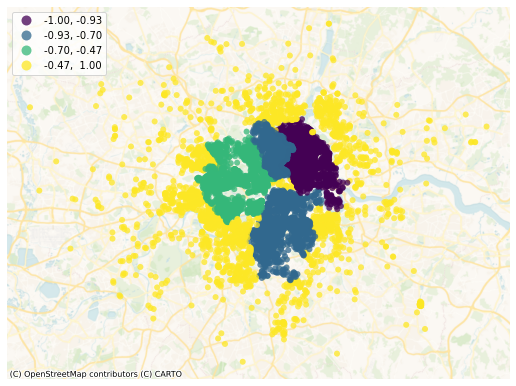

In [63]:
# Gentrification 2019 plotting
# Set up figure and a single axis
import contextily 


f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
new_gent19.plot(
    column="2019_Airbnb Component 1",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=new_gent19.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

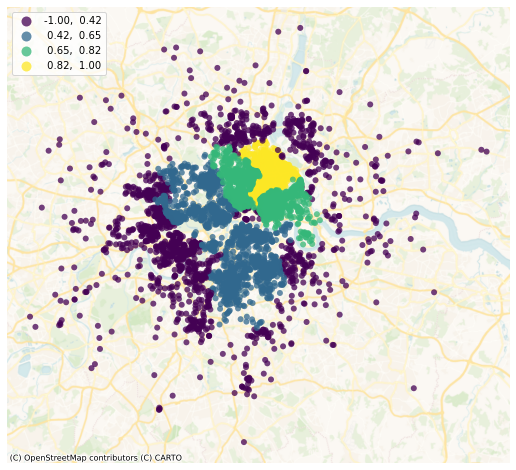

In [64]:
# Gentrification 2022 plotting
# Set up figure and a single axis
import contextily 


f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
new_gent22.plot(
    column="2022_Airbnb Component 1",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=new_gent22.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [65]:
# 30 listings in one neighbourhood can be thought of a sign that
# might indicate gentrification

# Create spatial weight matrix for 2019 gentrification data
df19 = new_gent19.reset_index()
knn19 = weights.KNN.from_dataframe(df19, k = 30)

# Create spatial weight matrix for 2019 gentrification data
df22 = new_gent22.reset_index()
knn22 = weights.KNN.from_dataframe(df22, k = 30)

# Row-standardization
knn19.transform = 'r'
knn22.transform = 'r'

In [66]:
# Spatial lag of our airbnb listings
# 2019 airbnb listings
df19["w_2019_Airbnb Component 1"] = weights.spatial_lag.lag_spatial(
    knn19, df19["2019_Airbnb Component 1"]
)

# 2022 airbnb listings
df22["w_2022_Airbnb Component 1"] = weights.spatial_lag.lag_spatial(
    knn22, df22["2022_Airbnb Component 1"]
)

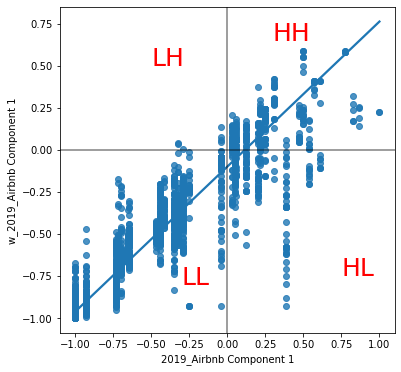

In [67]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x= "2019_Airbnb Component 1", y="w_2019_Airbnb Component 1", data=df19, ci=None
);

# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(0.3, 0.65, "HH", fontsize=25, c="r")
plt.text(0.75, -0.75, "HL", fontsize=25, c="r")
plt.text(-0.5, 0.5, "LH", fontsize=25, c="r")
plt.text(-0.3, -0.8, "LL", fontsize=25, c="r")
# Display
plt.show()

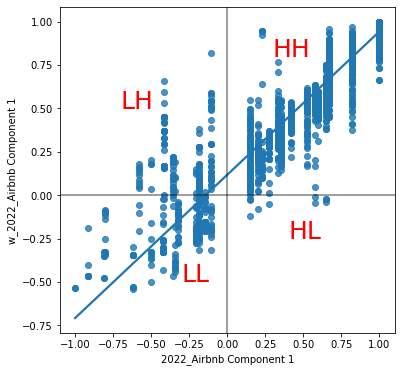

In [68]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x= "2022_Airbnb Component 1", y="w_2022_Airbnb Component 1", data=df22, ci=None
);

# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(0.3, 0.8, "HH", fontsize=25, c="r")
plt.text(0.4, -0.25, "HL", fontsize=25, c="r")
plt.text(-0.7, 0.5, "LH", fontsize=25, c="r")
plt.text(-0.3, -0.5, "LL", fontsize=25, c="r")
# Display
plt.show()

Using standardized values, we can immediately divide each variable 

The airbnb pca component, and its spatial lag in two groups: 

those with above-average airbnb listings, which have positive standardized values;


those with below-average airbnb listings, which have negative standardized values;

In [69]:
# Local Moran's I
lisa_19 = esda.Moran_Local(df19['2019_Airbnb Component 1'], knn19, seed = 42)
lisa_22 = esda.Moran_Local(df22['2022_Airbnb Component 1'], knn22, seed = 42)

We need to pass the variable of interest — Airbnb PCA Component 1 in this context — 

and the spatial weights that describe the neighborhood relations between the different areas that make up the dataset. 

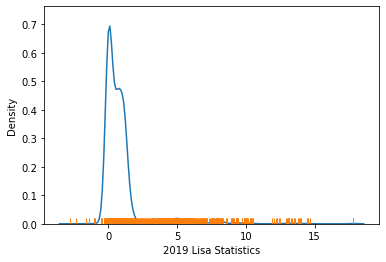

In [70]:
# Draw KDE line of list_19
ax = sns.kdeplot(lisa_19.Is)
plt.xlabel('2019 Lisa Statistics')
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa_19.Is, ax=ax);

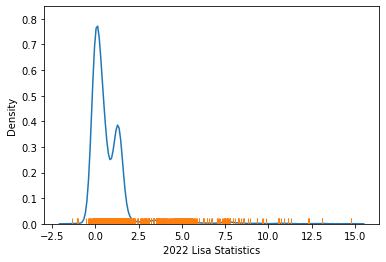

In [71]:
# Draw KDE line of list_22
ax = sns.kdeplot(lisa_22.Is)
plt.xlabel('2022 Lisa Statistics')
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa_22.Is, ax=ax);

Both firgures show a positively skewed distribution of local Moran'I statistics.

This indicates that most of Moran's I statistics values are positive.

Hence, we need to bear in mind that the high positive values arise from value similarity in space.

This can be due to either high values being next to high values or low values next to low values.

In other words, **Positive Autocorrelation**

But local Moran's I cannot distinguish which one it is between two.

### Choropleth plots of local Moran's I

In [72]:
# package
from splot import esda as esdaplot

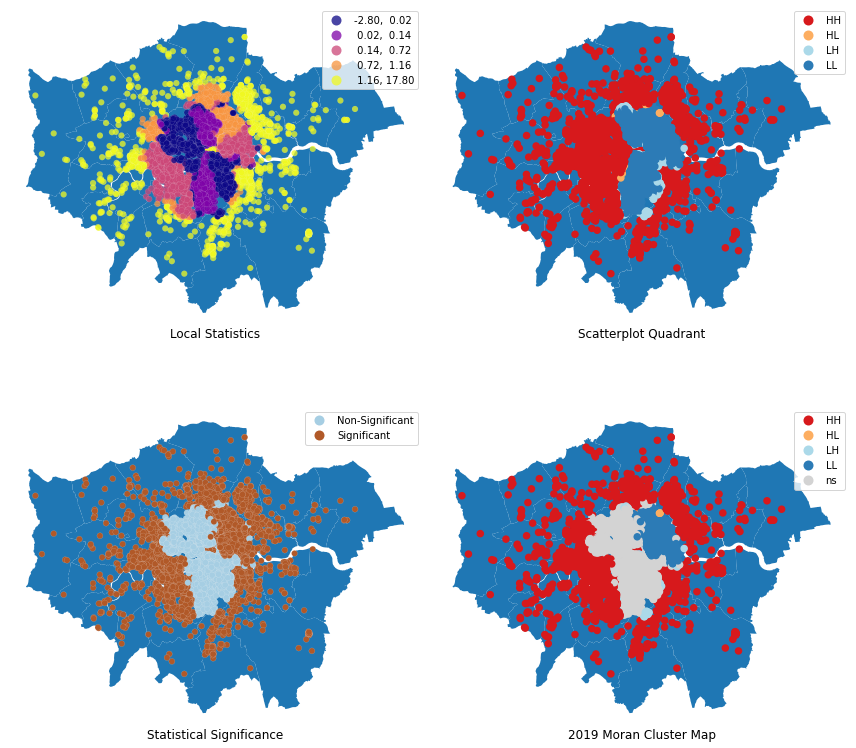

In [73]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# London borough map
boros.plot(ax = ax)
# Assign new column with local statistics on-the-fly
df19.assign(
    Is=lisa_19.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)


# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_19, df19, p=1, ax=ax)


# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
# London borough map
boros.plot(ax = ax)
# Find out significant observations
labels = pd.Series(
    1 * (lisa_19.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=df19.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
df19.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)




# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_19, df19, p=0.05, ax=ax)



# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "2019 Moran Cluster Map",
        ][i],
        y=-0.05,
    )
    

# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

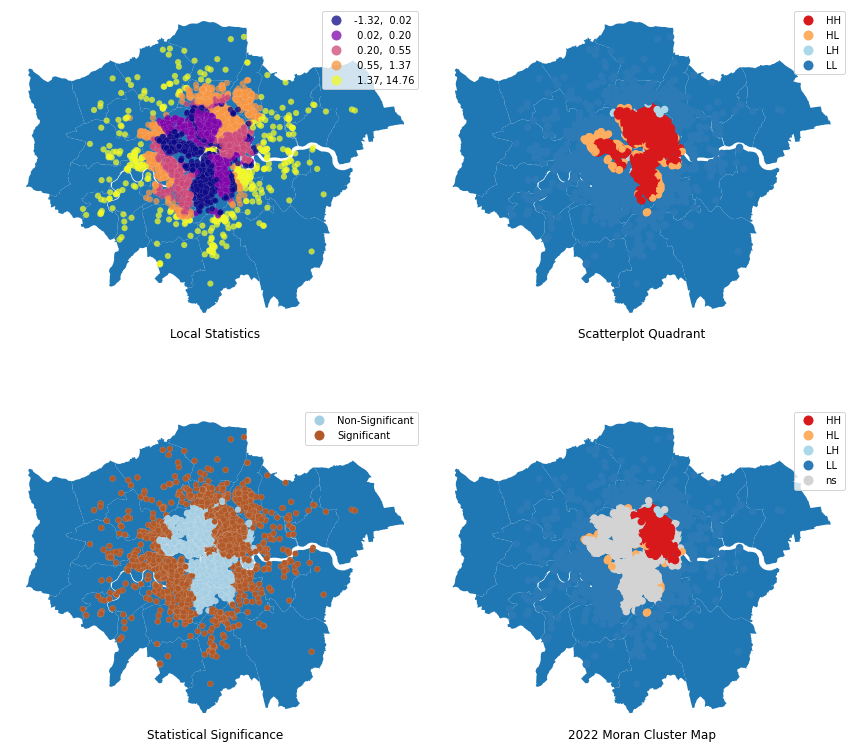

In [74]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# London borough map
boros.plot(ax = ax)
# Assign new column with local statistics on-the-fly
df22.assign(
    Is=lisa_22.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)


# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_22, df22, p=1, ax=ax)


# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
# London borough map
boros.plot(ax = ax)
# Find out significant observations
labels = pd.Series(
    1 * (lisa_22.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=df22.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
df22.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)




# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_22, df22, p=0.05, ax=ax)



# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "2022 Moran Cluster Map",
        ][i],
        y=-0.05,
    )
    

# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

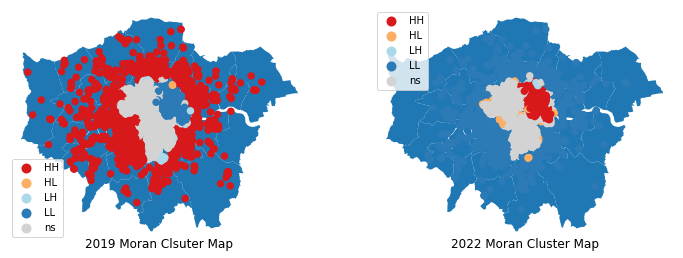

In [75]:
# 2019 Moran Cluster Map
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# London borough map
ax = axs[0]
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_19, df19, p=0.05, ax=ax)


# 2022 Moran Cluster Map
ax = axs[1]
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_22, df22, p=0.05, ax=ax)


# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "2019 Moran Clsuter Map",
            "2022 Moran Cluster Map",
        ][i],
        y=-0.05,
    )
    
plt.show()

### Insight

We can see a drastic change over the 3 years.
- In 2019 Moran Cluster Map, 'HH' values were spotted in Kensington and Chelsea, and Hammersmith and Fulham. 

- However, in 2022 Moran Cluster Map, 'HH' values were spotted in Hackney, Tower Hamlets and Islington regions.

These might indicate us that plausible gentrification is in the process or is already in place in Hackney, Tower Hamlets and Islington.

In [76]:
# count quadrant
# 1 means High-High quadrant
# 2 means Low-High quadrant
# 3 means Low-Low quadrant
# 4 means High-Low quadrant
counts19 = pd.value_counts(lisa_19.q)
counts22 = pd.value_counts(lisa_22.q)
print('Quadrant of 2019 Gentrification related Airbnb listings')
print(counts19)
print('--------------')
print('Quadrant of 2022 Gentrification related Airbnb listings')
print(counts22)

Quadrant of 2019 Gentrification related Airbnb listings
3    5814
1    4465
2     125
4      81
dtype: int64
--------------
Quadrant of 2022 Gentrification related Airbnb listings
1    3144
3    2245
4     259
2      56
dtype: int64


### Insight
- HH (1) and LL (3) values are predominant.
- The moran cluster map includes significance information alongside the quadrant and local statistic. Together, these maps extract significant observations -those that are highly unlikely to have come from pure chance- and plots them with a specific colour depending on their quadrant category. 

In [77]:
# Statistically significant lisa statistics
print('2019 Lisa Statistics')
print((lisa_19.p_sim < 0.05).sum() * 100 / len(lisa_19.p_sim))
print('-------------------------------------------------')
print('2022 Lisa Statistics')
print((lisa_22.p_sim < 0.05).sum() * 100 / len(lisa_22.p_sim))

2019 Lisa Statistics
62.107773009060566
-------------------------------------------------
2022 Lisa Statistics
63.49929873772791


Nearly two-thirds of polygons that have degrees of local spatial association strong enough to reject the idea of pure chance.

In 2019, **Zone 3, Kensington and Chelsea, and Fulham** areas indicate a high airbnb density. While we can see clearly a low density of airbnb in East London, boroughs like Hackney, Islington and Tower Hamlets.

However in 2022, **Hackney, Islington and Tower Hamlets** show a high airbnb density. We can see a clear change over the 3 years which tells us that speculative gentrification has happened in the said boroughs.

In [78]:
# Assign pseudo P-values to `df`
df19["p-sim"] = lisa_19.p_sim
df22["p-sim"] = lisa_22.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig19 = 1 * (lisa_19.p_sim < 0.05)
sig22 = 1 * (lisa_22.p_sim < 0.05)
# Assign significance flag to `db`
df19["sig19"] = sig19
df22["sig22"] = sig22

In [79]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots19 = lisa_19.q * sig19
spots22 = lisa_22.q * sig22

# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}

# Create column in `db` with labels for each polygon
df19["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots19,
    index=df19.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)

df22["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots22,
    index=df22.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)



In [80]:
df19.head(n=1)

,GSS_CODE,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry,w_2019_Airbnb Component 1,p-sim,sig19,labels
0,E09000001,0.39,1.00,1.00,POINT (532283.423 181370.784),-0.10,0.00,1,HH


In [81]:
# Filter HH, LH and HL as they could be related to gentrification or under gentrification threat
probable_gent19 = df19.loc[(df19['labels'] == 'HH') | (df19['labels'] == 'HL') |
                              (df19['labels'] == 'LH')]

probable_gent22 = df22.loc[(df22['labels'] == 'HH') | (df22['labels'] == 'HL') |
                              (df22['labels'] == 'LH')]

In [82]:
# 2019 gentrification related listings per borough
probable_gent19.GSS_CODE.value_counts()

E09000020    556
E09000013    377
E09000032    339
E09000005    240
E09000014    234
E09000023    199
E09000031    186
E09000025     90
E09000009     76
E09000006     74
E09000011     71
E09000008     69
E09000003     57
E09000024     48
E09000018     43
E09000007     40
E09000033     38
E09000027     32
E09000001     31
E09000002     20
E09000015     18
E09000010     18
E09000022     16
E09000028     16
E09000021     13
E09000026     11
E09000016      7
E09000019      6
E09000017      5
E09000029      4
E09000030      2
E09000004      2
Name: GSS_CODE, dtype: int64

In [83]:
# 2022 gentrification related listings per borough
probable_gent22.GSS_CODE.value_counts()

E09000012    1217
E09000030     686
E09000019     109
E09000028      20
E09000033      19
E09000031       4
E09000014       2
E09000025       1
Name: GSS_CODE, dtype: int64

### Interpretation of Local Moran's I
- We've filtered `speculative gentrification-associated listings` based on regular expressions. We cannot capture all the gentrification-related listings but the regex we've applied can be a good indicator of grasping airbnb's impact on London.

- Areas labelled as HL or LH can be thought of boroughs under gentrification threats. **HL** means high values are surrounded by low values so this might tell us that some areas are under airbnb's expansion. **LH** means low values are surrounded by high values so we could think these are the areas at gentrification risk.

- In 2019, **Kensington and Chelsea, Hammersmith and Fulham, and Wandsworth** were top 3 boroughs that showed high densities of airbnb with respect to gentrification-related listings search.

- In 2022, **Hackney, Islington and Tower Hamlets** were top 3 boroughs with respect to gentrification-related listings. In particular, these boroughs were in LL in 2019, however, in 2022, all these boroughs show HH quadrant in moran cluster map.

## Export 2022 Airbnb listings 

- Kensingotn and Chelsea: High density of gentrification-related listings in 2019
- Hackney: High density of gentrification-related listings in 2022
- Camden: Moderate density of gentrification-related listings in 2019

In [84]:
gl22 = gdf_2022.dropna(thresh=len(gdf_2022.columns)-1)
print(f"The dataset now has {gl22.shape[0]:,} rows after dropping those with more than 1 null value")

The dataset now has 69,054 rows after dropping those with more than 1 null value


In [85]:
# filter target boroughs from 2022 airbnb listing data
kc = gl22[gl22.borough.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} listings in the cleaned geodataset for listings in Kensington and Chelsea")

Camden = gl22[gl22.borough.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} listings in the cleaned geodataset for listings in Camden")

hack = gl22[gl22.borough.str.contains(r'Hackney', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {hack.shape[0]:,} listings in the cleaned geodataset for listings in Hackney")

Found 4,596 listings in the cleaned geodataset for listings in Kensington and Chelsea
Found 4,684 listings in the cleaned geodataset for listings in Camden
Found 5,164 listings in the cleaned geodataset for listings in Hackney


In [86]:
# save each borough's listings in feather file format
#kc listings
kc.drop(axis=1,columns=['geometry'])
kc.to_feather('listings22_kensington_chelsea')

#camden listings
Camden.drop(axis=1,columns=['geometry'])
Camden.to_feather('listings22_camden')

#hackney listings
hack.drop(axis=1, columns=['geometry'])
hack.to_feather('listings22_hackney')

# Gentrification-related listings
gent22.to_feather('listings22_gentrification')

## Deprivation Mapping 

### Import Data 

#### London LSOA shapefile

In [87]:
lsoa_shp_file = gpd.read_file('LSOA & Dep Data/ESRI/LSOA_2011_London_gen_MHW.shp')

#### Airbnb listings

In [88]:
# 2022 airbnb listing data
listings2022 = airbnb_2022.copy()

In [89]:
# 2022 airbnb listings in Kensington and Chelsea 
listings2022_kensington_chelsea = pd.read_feather('listings22_kensington_chelsea')

In [90]:
# 2022 airbnb listings in Camden
listings2022_camden = pd.read_feather('listings22_camden')

In [91]:
# 2022 airbnb listings in Hackney
listings2022_hackney = pd.read_feather('listings22_hackney')

In [92]:
# 2022 gentrification-related listings
listings2022_gentrification = pd.read_feather('listings22_gentrification')

#### Eviction Data

**While we included eviction data in compiling our datasets, we are not including it in the subsequent work. This is largely due to the complicated nature of the data. Notably, the number of evictions is very low in comparison to other major cities around the world like New York. In 2019, Westminster had the highest number: 48. This number - which technically refers to reposession of property due to defaulting on mortgages or otherwise - is only the official record. It is unlikely that it reflect the reality of how many people are actually evicted every year extrajudicially. In other words, informal living arragements complicate how one can quantify disposession of property by those in power. Nonetheless, we are including the dataset as it may serve future research. More information on the dataset can be found at https://data.london.gov.uk/dataset/mortgage-and-landlord-possession-actions-borough.**

In [93]:
evict2019 = pd.read_csv('2019_evictions_geom')

In [94]:
evict2022 = pd.read_csv('2022_evictions_geom')

#### Read in LSOA & IMD Data
This data is for each borough that we are targetting but broken down into LSOAs so we can get a more micro level view of deprivation there.

In [95]:
hackney_dep = pd.read_csv('LSOA & Dep Data/hackLSOA_dep')

In [96]:
camden_dep = pd.read_csv('LSOA & Dep Data/CamdenLSOA_dep')

In [97]:
kc_dep = pd.read_csv('LSOA & Dep Data/kcLSOA_dep')

In [98]:
London_dep = pd.read_csv('LSOA & Dep Data/London_dep')

In [99]:
London_dep.columns.tolist()

['Unnamed: 0',
 'LSOA11CD',
 'LSOA11NM',
 'geometry',
 'LSOA code (2011)',
 'Local Authority District code (2019)',
 'LAD',
 'Barriers to Housing and Services Score',
 'Barriers to Housing and Services Rank (where 1 is most deprived)',
 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)',
 'transformed_mms']

In [100]:
London_borough_dep = London_dep.groupby('LAD')['Barriers to Housing and Services Score'].agg('mean')

In [101]:
London_borough_dep.info(verbose=True)

<class 'pandas.core.series.Series'>
Index: 33 entries, Barking and Dagenham to Westminster
Series name: Barriers to Housing and Services Score
Non-Null Count  Dtype  
--------------  -----  
33 non-null     float64
dtypes: float64(1)
memory usage: 528.0+ bytes


### Merging 2022 Airbnb Data: All London

In [102]:
airbnb_merged1 = pd.merge(listings2022, evict2022, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='Area', suffixes=('neighbourhood_cleansed', 'Area'))

In [103]:
airbnb_merged2 = pd.merge(airbnb_merged1, London_borough_dep, how="inner", left_on='neighbourhood_cleansed', 
                          right_on='LAD', suffixes=('neighbourhood_cleansed', 'Area'))

In [104]:
airbnb_merged2 = gpd.GeoDataFrame(airbnb_merged2, geometry=gpd.points_from_xy(airbnb_merged2.longitude, airbnb_merged2.latitude))
airbnb_merged2.set_crs(epsg=4326, inplace=True)
airbnb_merged2 = airbnb_merged2.to_crs('epsg:27700')

In [105]:
airbnb_merged2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69351 entries, 0 to 69350
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      69351 non-null  int64   
 1   name                                    69330 non-null  object  
 2   description                             67832 non-null  object  
 3   host_id                                 69351 non-null  int64   
 4   host_location                           56984 non-null  category
 5   host_listings_count                     69346 non-null  UInt16  
 6   host_total_listings_count               69346 non-null  UInt16  
 7   latitude                                69351 non-null  float64 
 8   longitude                               69351 non-null  float64 
 9   property_type                           69351 non-null  category
 10  room_type                             

In [106]:
# crs is in British local crs
print(airbnb_merged2.crs)

epsg:27700


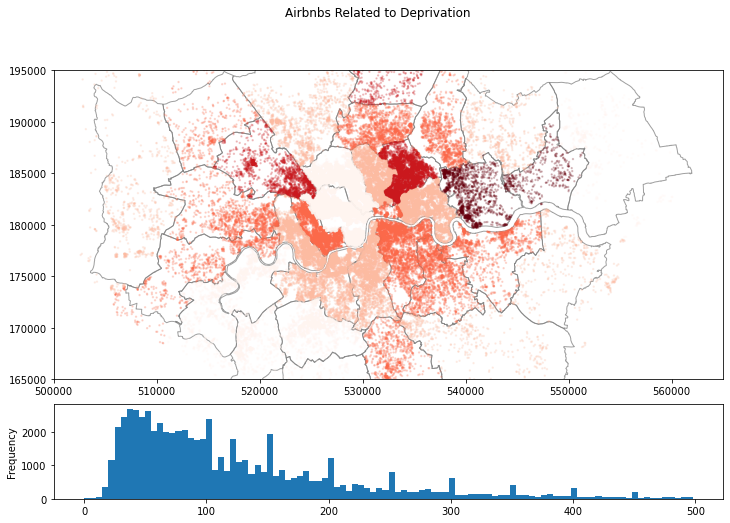

In [107]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
airbnb_merged2.plot(markersize=2, column='Barriers to Housing and Services Score', cmap='Reds', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
airbnb_merged2[airbnb_merged2.price<airbnb_merged2.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Airbnbs Related to Deprivation")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Merging 2022 Airbnb Data & LSOA: Gentrification Regex

In [108]:
listings2022_gentrification.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,...,minimum_nights,maximum_nights,borough,price,geometry_x,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry_y
0,107048,A Luxury Studio Suite in Clerkenwell,"Situated in the heart of vibrant Clerkenwell, ...",259088,United Kingdom,5,12,51.52,-0.10,Private room in loft,...,4,365,Islington,180.00,b'\x01\x01\x00\x00\x00>\x90@\x03\xe88 A\xee\xa...,E09000019,"1,485.66",0.00,T,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...


In [109]:
airbnb_merged1 = pd.merge(listings2022_gentrification, evict2022, how="inner", left_on='borough', 
                          right_on='Area', suffixes=('borough', 'Area'))

In [110]:
airbnb_merged2 = pd.merge(airbnb_merged1, London_borough_dep, how="inner", left_on= 'borough',
                          right_on='LAD', suffixes=('borough', 'Area'))

In [111]:
airbnb_merged2 = gpd.GeoDataFrame(airbnb_merged2, geometry=gpd.points_from_xy(airbnb_merged2.longitude, airbnb_merged2.latitude))
airbnb_merged2.crs = {'init': 'epsg:4326'}
airbnb_merged2 = airbnb_merged2.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


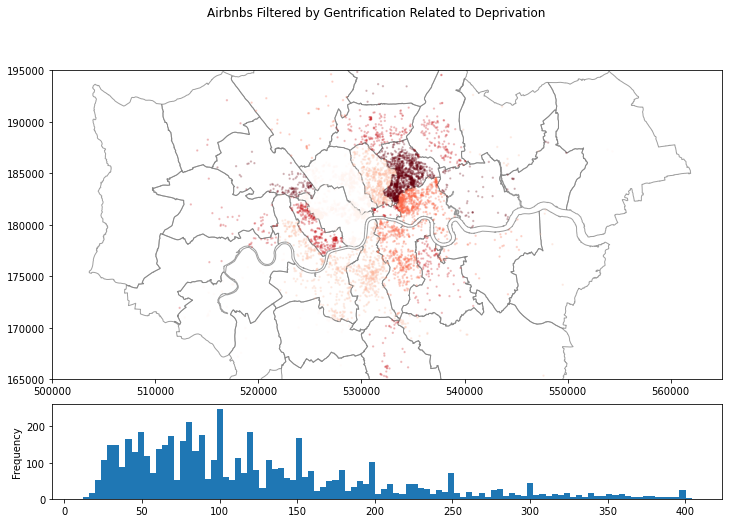

In [112]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
airbnb_merged2.plot(markersize=2, column='Barriers to Housing and Services Score', cmap='Reds', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
airbnb_merged2[airbnb_merged2.price<airbnb_merged2.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Airbnbs Filtered by Gentrification Related to Deprivation")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

In [113]:
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
bfont = {'fontname':'Liberation Sans Narrow', 'weight':'normal', 'horizontalalignment':'left'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

In [114]:
H = 'Hackney'
K = 'Kensington and Chelsea'
C = 'Camden'

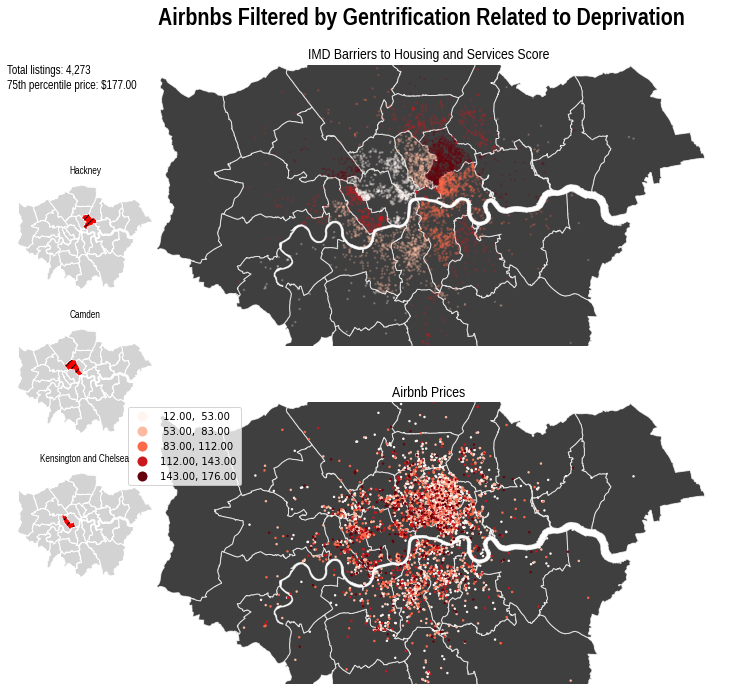

In [115]:
f,axes = plt.subplots(2,1,figsize=(12,8))

# Set up the plots
ax1 = axes[0]
ax1.set_title('IMD Barriers to Housing and Services Score', size=15, **afont)
boros.plot(edgecolor='white', facecolor='black', linewidth=1, alpha=0.75, ax=ax1)
airbnb_merged2.plot(markersize=2, column='Barriers to Housing and Services Score', cmap='Reds', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)
ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000])

ax2 = axes[1]
ax2.set_title('Airbnb Prices', size=15, **afont)
price_75 = airbnb_merged2['price'].quantile(0.75)
price_gdf = price_gdf = airbnb_merged2[airbnb_merged2.price < price_75]
boros.plot(edgecolor='white', facecolor='black', linewidth=1, alpha=0.75, ax=ax2)
price_gdf.plot(column='price', markersize=2, ax=ax2, legend=True, cmap='Reds', scheme='Fisher_Jenks_Sampled')
ax2.set_xlim([500000, 565000])
ax2.set_ylim([165000, 195000])

ax3 = f.add_axes([0.015, 0.8, 0.2, 0.2])
ax3.set_title('Hackney', size=10, **afont)
boros.plot(facecolor='lightgrey', edgecolor='w', linewidth=1, ax=ax3)
boros[boros.NAME== H].plot(facecolor='r', edgecolor='none', hatch='///', ax=ax3)
ax3.axis('off')

ax4 = f.add_axes([0.015, 0.55, 0.2, 0.2])
ax4.set_title('Camden', size=10, **afont)
boros.plot(facecolor='lightgrey', edgecolor='w', linewidth=1, ax=ax4)
boros[boros.NAME== C].plot(facecolor='r', edgecolor='none', hatch='///', ax=ax4)
ax4.axis('off')

ax5 = f.add_axes([0.015, 0.3, 0.2, 0.2])
ax5.set_title('Kensington and Chelsea', size=10, **afont)
boros.plot(facecolor='lightgrey', edgecolor='w', linewidth=1, ax=ax5)
boros[boros.NAME== K].plot(facecolor='r', edgecolor='none', hatch='///', ax=ax5)
ax5.axis('off')

for ax in axes:
    ax.axis('off')
    ax.set_facecolor((.4, .4, .4, .2))

f.subplots_adjust(top=1.2) # adjust the distance between the maps and the title
f.suptitle("Airbnbs Filtered by Gentrification Related to Deprivation", x=0.2,y=1.3, ha='left', size=24, **tfont)
plt.figtext(x=0.025, y=1.2, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {price_gdf['price'].count():,.0f}\n75th percentile price: ${price_75:,.2f}", **bfont)
plt.show()


### Merging 2022 Airbnb Data & LSOA: Kensington and Chelsea

In [116]:
listings2022_kensington_chelsea = gpd.GeoDataFrame(listings2022_kensington_chelsea, geometry=gpd.points_from_xy(listings2022_kensington_chelsea.longitude, listings2022_kensington_chelsea.latitude))
listings2022_kensington_chelsea.crs = {'init': 'epsg:4326'}
listings2022_kensington_chelsea = listings2022_kensington_chelsea.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [117]:
kc_deprivation = lsoa_shp_file.merge(kc_dep, how="inner", left_on='LSOA11CD', right_on='LSOA11CD')

In [118]:
to_drop = ['LSOA11NM_x', 'MSOA11CD','MSOA11NM','LAD11CD','LAD11NM','RGN11CD','RGN11NM',
 'USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ','geometry_y','Unnamed: 0', 'LSOA11NM_y']
kc_deprivation = kc_deprivation.drop(axis=1, columns=to_drop)
#transformed mms comes from the eviction dataset where I used min-max scaler to standardise the eviction data

In [119]:
kc_deprivation_geometry = kc_deprivation.set_geometry('geometry_x')

In [120]:
kc_listings = listings2022_kensington_chelsea.merge(kc_deprivation, how="left", left_on='borough', right_on='LAD')

In [121]:
kc_listings = kc_listings.drop_duplicates(subset=['id'])

In [122]:
kc_listings.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,...,geometry,LSOA11CD,geometry_x,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms
0,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,"Kensington, United Kingdom",1,12,51.49,-0.17,Entire rental unit,...,POINT (527284.576 178129.679),E01002812,"POLYGON ((525802.225 179074.026, 525809.313 17...",E01002812,E09000020,Kensington and Chelsea,40.75,1981,1,0.53


In [123]:
kc_listings = gpd.GeoDataFrame(kc_listings, geometry=gpd.points_from_xy(kc_listings.longitude, kc_listings.latitude))
kc_listings.crs = {'init': 'epsg:4326'}
kc_listings = kc_listings.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


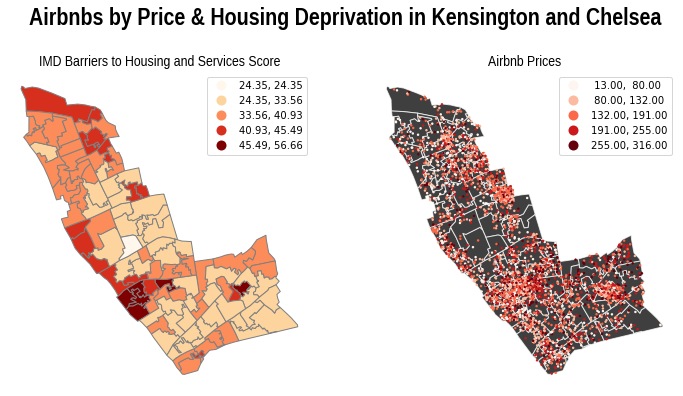

In [124]:
f,axes = plt.subplots(1,2,figsize=(12,8))

ax1 = axes[0]
ax1.set_title('IMD Barriers to Housing and Services Score', size=15, **afont)
kc_deprivation_geometry.plot(column='Barriers to Housing and Services Score', legend=True, scheme='Fisher_Jenks_Sampled', cmap = 'OrRd',
                             edgecolor='grey', facecolor='black', linewidth=1, alpha=1, ax=ax1)
 
ax2 = axes[1]
ax2.set_title('Airbnb Prices', size=15, **afont)
price_75 = kc_listings['price'].quantile(0.75)
price_gdf = price_gdf = kc_listings[kc_listings.price < price_75]
kc_deprivation_geometry.plot(edgecolor='white', facecolor='black', linewidth=1, alpha=0.75, ax=ax2)
price_gdf.plot(column='price', markersize=2, ax=ax2, legend=True, cmap='Reds', scheme='Fisher_Jenks_Sampled')

for ax in axes:
    ax.axis('off')
    ax.set_facecolor((.4, .4, .4, .2))

f.subplots_adjust(top=1.5) # adjust the distance between the maps and the title
f.suptitle("Airbnbs by Price & Housing Deprivation in Kensington and Chelsea", x=0.15,y=1.2, ha='left', size=24, **tfont)

plt.show()


### Merging 2022 Airbnb Data: Camden

In [125]:
listings2022_camden = gpd.GeoDataFrame(listings2022_camden, geometry=gpd.points_from_xy(listings2022_camden.longitude, listings2022_camden.latitude))
listings2022_camden.crs = {'init': 'epsg:4326'}
listings2022_camden = listings2022_camden.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [126]:
camden_deprivation = lsoa_shp_file.merge(camden_dep, how="inner", left_on='LSOA11CD', right_on='LSOA11CD')

In [127]:
to_drop_c = ['LSOA11NM_x', 'MSOA11CD','MSOA11NM','LAD11CD','LAD11NM','RGN11CD','RGN11NM',
 'USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ','geometry_y','Unnamed: 0', 'LSOA11NM_y']
camden_deprivation = camden_deprivation.drop(axis=1, columns=to_drop_c)
#transformed mms comes from the eviction dataset where I used min-max scaler to standardise the eviction data

In [128]:
camden_deprivation.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 132
Data columns (total 9 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         133 non-null    object  
 1   geometry_x                                                                       133 non-null    geometry
 2   LSOA code (2011)                                                                 133 non-null    object  
 3   Local Authority District code (2019)                                             133 non-null    object  
 4   LAD                                                                              133 non-null    object  
 5   Barriers to Housing and Services Score                                           133 non-null    float64 
 6   Bar

In [129]:
camden_deprivation_geometry = camden_deprivation.set_geometry('geometry_x')

In [130]:
camden_deprivation_geometry.plot(column='Barriers to Housing and Services Score', legend=True, scheme='Fisher_Jenks_Sampled',cmap = 'OrRd',
                                 edgecolor='grey', facecolor='black', linewidth=1, alpha=1, ax=ax1)

<AxesSubplot:title={'center':'IMD Barriers to Housing and Services Score'}>

<Figure size 432x288 with 0 Axes>

In [131]:
camden_listings = listings2022_camden.merge(camden_deprivation, how="left", left_on='borough', right_on='LAD')

In [132]:
camden_listings = camden_listings.drop_duplicates(subset=['id'])

In [133]:
camden_listings.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4684 entries, 0 to 622839
Data columns (total 25 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   id                                                                               4684 non-null   int64   
 1   name                                                                             4683 non-null   object  
 2   description                                                                      4625 non-null   object  
 3   host_id                                                                          4684 non-null   int64   
 4   host_location                                                                    3802 non-null   category
 5   host_listings_count                                                              4684 non-null   UInt

In [134]:
camden_listings = gpd.GeoDataFrame(camden_listings, geometry=gpd.points_from_xy(camden_listings.longitude, camden_listings.latitude))
camden_listings.crs = {'init': 'epsg:4326'}
camden_listings = camden_listings.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [135]:
camden_deprivation_geometry.head(n=1)

,LSOA11CD,geometry_x,LSOA code (2011),Local Authority District code (2019),LAD,Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),transformed_mms
0,E01000842,"POLYGON ((527317.841 184750.587, 527357.075 18...",E01000842,E09000007,Camden,20.65,15883,5,0.22


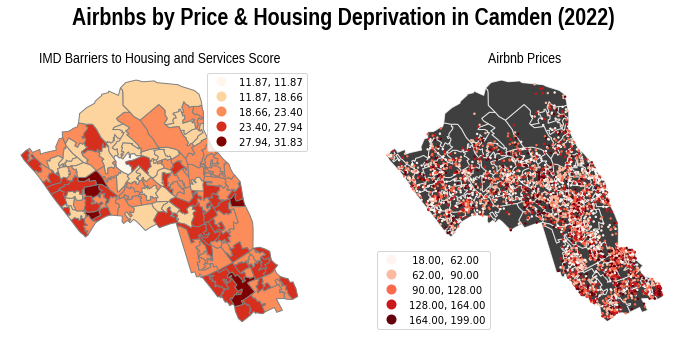

In [136]:
f,axes = plt.subplots(1,2,figsize=(12,8))

# Set up the plots
ax1 = axes[0]
ax1.set_title('IMD Barriers to Housing and Services Score', size=15, **afont)
camden_deprivation_geometry.plot(column='Barriers to Housing and Services Score', legend=True, scheme='Fisher_Jenks_Sampled',cmap = 'OrRd',
                                 edgecolor='grey', facecolor='black', linewidth=1, alpha=1, ax=ax1)

ax2 = axes[1]
ax2.set_title('Airbnb Prices', size=15, **afont)
price_75 = camden_listings['price'].quantile(0.75)
price_gdf = price_gdf = camden_listings[camden_listings.price < price_75]
camden_deprivation_geometry.plot(edgecolor='white', facecolor='black', linewidth=1, alpha=0.75, ax=ax2)
price_gdf.plot(column='price', markersize=2, ax=ax2, legend=True, cmap='Reds', scheme='Fisher_Jenks_Sampled')

for ax in axes:
    ax.axis('off')
    ax.set_facecolor((.4, .4, .4, .2))

f.subplots_adjust(top=1.2) # adjust the distance between the maps and the title
f.suptitle("Airbnbs by Price & Housing Deprivation in Camden (2022)", x=0.2,y=1, ha='left', size=24, **tfont)

plt.show()

### Merging 2022 Airbnb Data: Hackney

In [137]:
listings2022_hackney = gpd.GeoDataFrame(listings2022_hackney, geometry=gpd.points_from_xy(listings2022_hackney.longitude, listings2022_hackney.latitude))
listings2022_hackney.crs = {'init': 'epsg:4326'}
listings2022_hackney = listings2022_hackney.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [138]:
hackney_deprivation = lsoa_shp_file.merge(hackney_dep, how="inner", left_on='LSOA11CD', right_on='LSOA11CD')

In [139]:
to_drop = ['LSOA11NM_x', 'MSOA11CD','MSOA11NM','LAD11CD','LAD11NM','RGN11CD','RGN11NM',
 'USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ','geometry_y','Unnamed: 0', 'LSOA11NM_y']
hackney_deprivation = hackney_deprivation.drop(axis=1, columns=to_drop)
#transformed mms comes from the eviction dataset where I used min-max scaler to standardise the eviction data

In [140]:
hackney_deprivation.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 9 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   LSOA11CD                                                                         144 non-null    object  
 1   geometry_x                                                                       144 non-null    geometry
 2   LSOA code (2011)                                                                 144 non-null    object  
 3   Local Authority District code (2019)                                             144 non-null    object  
 4   LAD                                                                              144 non-null    object  
 5   Barriers to Housing and Services Score                                           144 non-null    float64 
 6   Bar

In [141]:
hackney_deprivation_geometry = hackney_deprivation.set_geometry('geometry_x')

In [142]:
hackney_listings = listings2022_hackney.merge(hackney_deprivation, how="left", left_on='borough', right_on='LAD')

In [143]:
hackney_listings = hackney_listings.drop_duplicates(subset=['id'])

In [144]:
hackney_listings.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5164 entries, 0 to 743472
Data columns (total 25 columns):
 #   Column                                                                           Non-Null Count  Dtype   
---  ------                                                                           --------------  -----   
 0   id                                                                               5164 non-null   int64   
 1   name                                                                             5162 non-null   object  
 2   description                                                                      5098 non-null   object  
 3   host_id                                                                          5164 non-null   int64   
 4   host_location                                                                    4647 non-null   category
 5   host_listings_count                                                              5164 non-null   UInt

In [145]:
hackney_listings = gpd.GeoDataFrame(hackney_listings, geometry=gpd.points_from_xy(hackney_listings.longitude, hackney_listings.latitude))
hackney_listings.crs = {'init': 'epsg:4326'}
hackney_listings = hackney_listings.to_crs('epsg:27700')

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


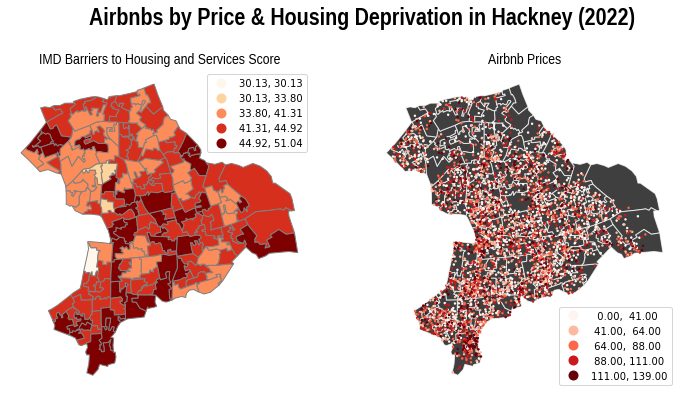

In [146]:
f,axes = plt.subplots(1,2,figsize=(12,8))

ax1 = axes[0]
ax1.set_title('IMD Barriers to Housing and Services Score', size=15, **afont)
hackney_deprivation_geometry.plot(column='Barriers to Housing and Services Score', legend=True, scheme='Fisher_Jenks_Sampled',cmap = 'OrRd',
                                 edgecolor='grey', facecolor='black', linewidth=1, alpha=1, ax=ax1)

ax2 = axes[1]
ax2.set_title('Airbnb Prices', size=15, **afont)
price_75 = hackney_listings['price'].quantile(0.75)
price_gdf = price_gdf = hackney_listings[hackney_listings.price < price_75]
hackney_deprivation_geometry.plot(edgecolor='white', facecolor='black', linewidth=1, alpha=0.75, ax=ax2)
price_gdf.plot(column='price', markersize=2, ax=ax2, legend=True, cmap='Reds', scheme='Fisher_Jenks_Sampled')

for ax in axes:
    ax.axis('off')
    ax.set_facecolor((.4, .4, .4, .2))

f.subplots_adjust(top=1.2) # adjust the distance between the maps and the title
f.suptitle("Airbnbs by Price & Housing Deprivation in Hackney (2022)", x=0.22,y=1.05, ha='left', size=24, **tfont)

plt.show()